In [ ]:
# uncomment if you haven't installed the package
# !pip install -e "git+https://github.com/daffarobani/smt-explainability.git"#egg=smt-ex
# !pip install sobolsampling

In [17]:
from smt.surrogate_models import KRG
from smt_ex.problems import MixedCantileverBeam
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from smt.applications.mixed_integer import MixedIntegerKrigingModel

from smt_ex.pdp.partial_dependence_display import PartialDependenceDisplay
from smt_ex.pdp.pd_feature_importance_display import PDFeatureImportanceDisplay
from smt_ex.pdp.pd_interaction_display import PDFeatureInteractionDisplay

from sklearn.metrics import mean_squared_error
import numpy as np
import time

In [13]:
ndoe = 250
n_train = int(0.8 * ndoe)
fun = MixedCantileverBeam()
# Name of the features
feature_names = [r'$\tilde{I}$', r'$L$', r'$S$']
# Index for categorical features
categorical_feature_indices = [0]
# Design space
ds = DesignSpace([
    CategoricalVariable(values=[str(i + 1) for i in range(12)]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_indices:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for i, value in enumerate(ds._design_variables[feature_idx].values)
    }

X = fun.sample(ndoe)
y = fun(X)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

class GroundTruthModel:
    def predict_values(self, X):
        return fun(X)
    
gtm = GroundTruthModel()

In [18]:
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )


start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

/Users/muhammaddaffarobani/miniconda3/envs/smt_ex_39/lib/python3.9/site-packages/smt/applications/mixed_integer.py:205: UserWarning: TNC not available yet for mixed integer handling. Switching to Cobyla
  warnings.warn(


run time (s): 30.250304698944092
Surrogate model
RMSE: 0.0000
rRMSE: 0.0253


/Users/muhammaddaffarobani/miniconda3/envs/smt_ex_39/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


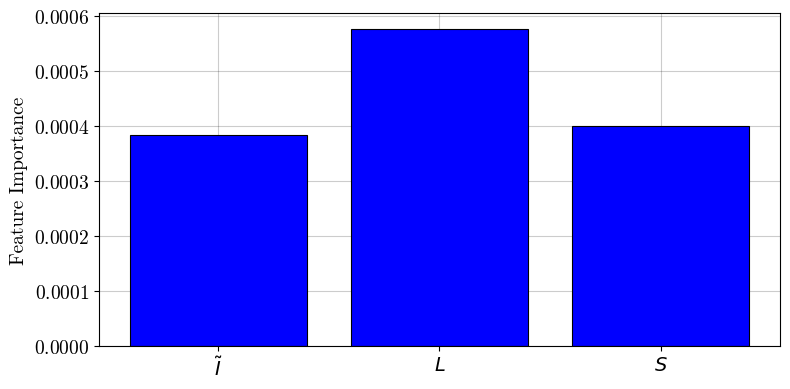

In [19]:
model = gtm

gt_pdd_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, X_tr, feature_names=feature_names, categorical_feature_indices=categorical_feature_indices
)
gt_pdd_importance.plot(figsize=[8, 4])

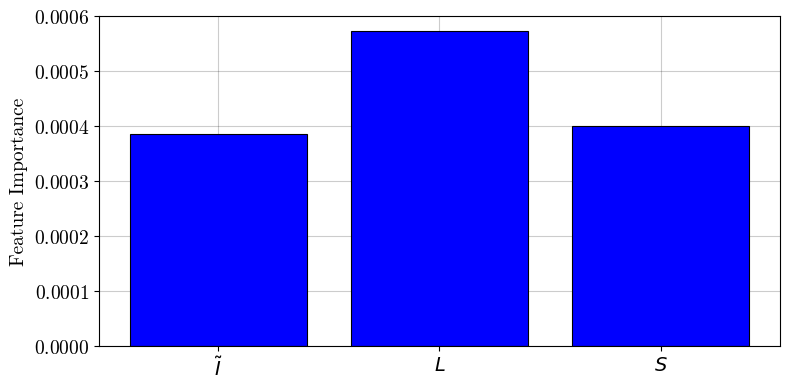

In [20]:
model = sm

sm_pdd_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, X_tr, feature_names=feature_names, categorical_feature_indices=categorical_feature_indices
)
sm_pdd_importance.plot(figsize=[8, 4])

CPU times: user 146 ms, sys: 34.7 ms, total: 181 ms
Wall time: 202 ms


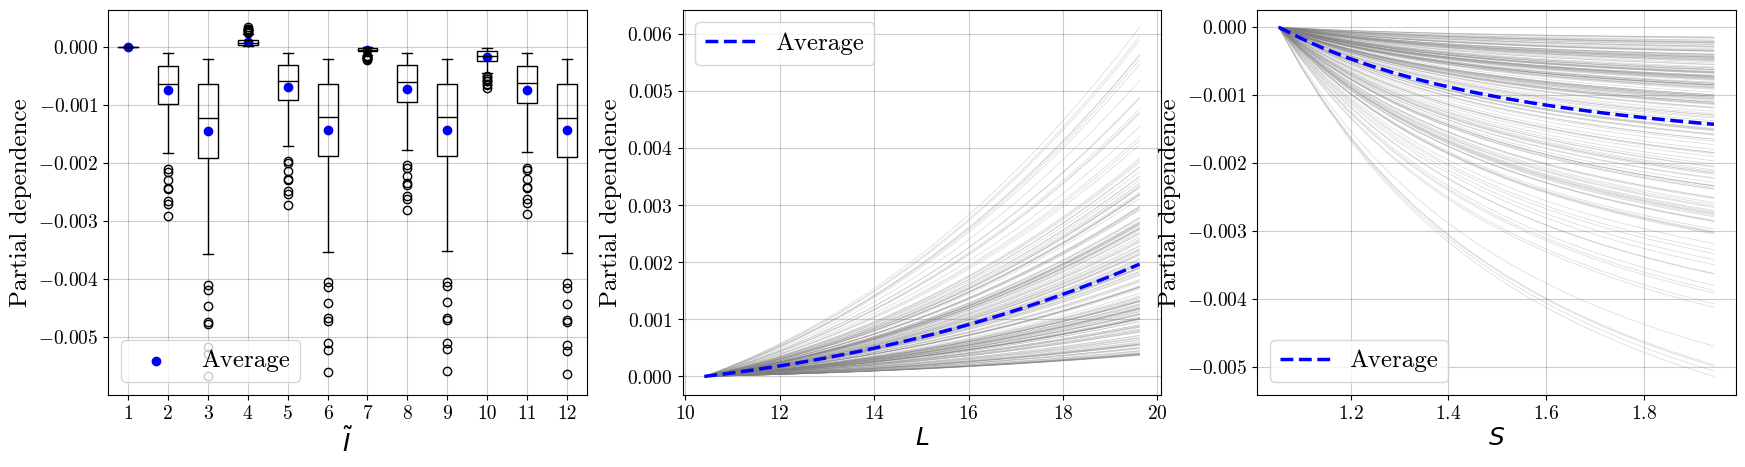

In [21]:
%%time
model = gtm

features = [i for i in range(X_tr.shape[1])]

gt_pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    features, 
    categorical_feature_indices=categorical_feature_indices, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    categories_map=categories_map,
    )

gt_pdd_plot_1d = gt_pdd.plot(centered=True)
gt_pdd_plot_1d

CPU times: user 1min 14s, sys: 1min 16s, total: 2min 31s
Wall time: 20.6 s


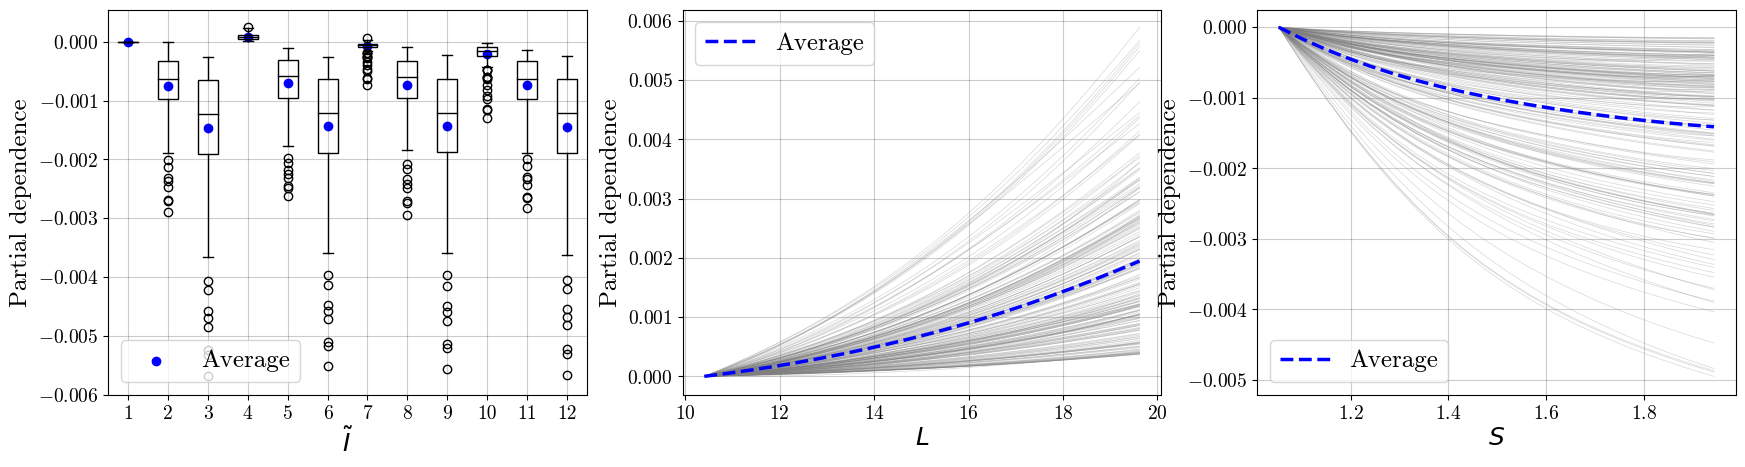

In [22]:
%%time
model = sm

features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X_tr, 
    features, 
    categorical_feature_indices=categorical_feature_indices, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    categories_map=categories_map,
    )

pdd_plot_1d = pdd.plot(centered=True)
pdd_plot_1d

CPU times: user 65.5 ms, sys: 11.7 ms, total: 77.2 ms
Wall time: 78.5 ms


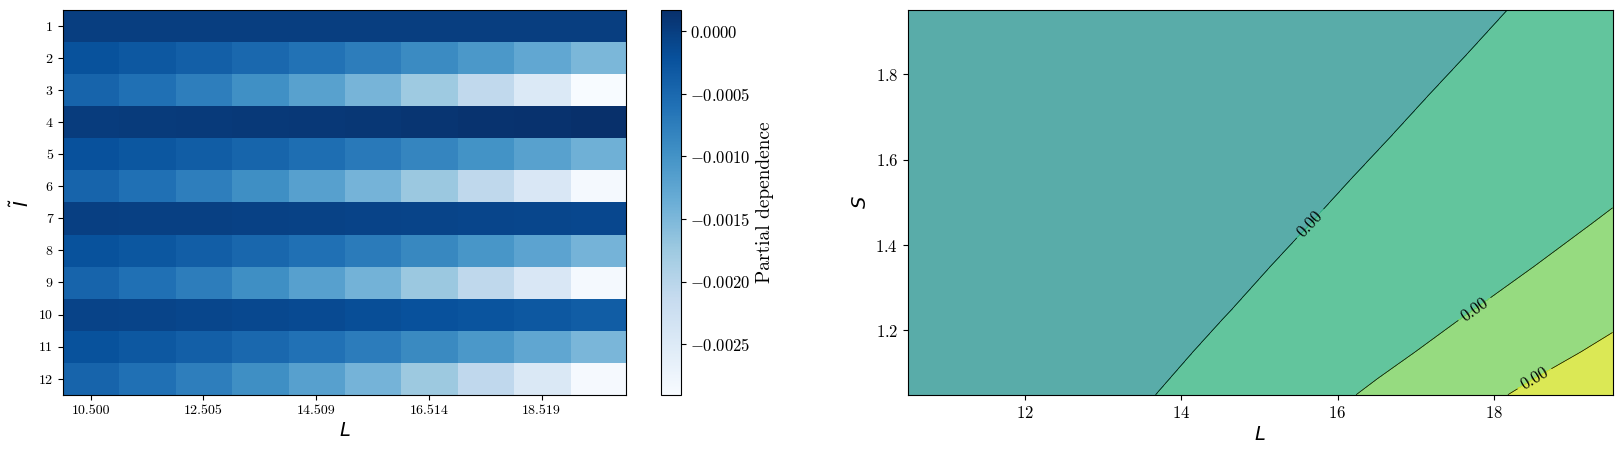

In [23]:
%%time
model = gtm
features = [(0, 1), (1, 2)]

gt_pdd_2d = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_feature_indices=categorical_feature_indices, 
    feature_names=feature_names,
    grid_resolution=10,
    kind='both',
    categories_map=categories_map,
    )

gt_pdd_2d.plot(centered=True, figsize=[20, 5])

CPU times: user 5min 5s, sys: 7min 12s, total: 12min 18s
Wall time: 1min 47s


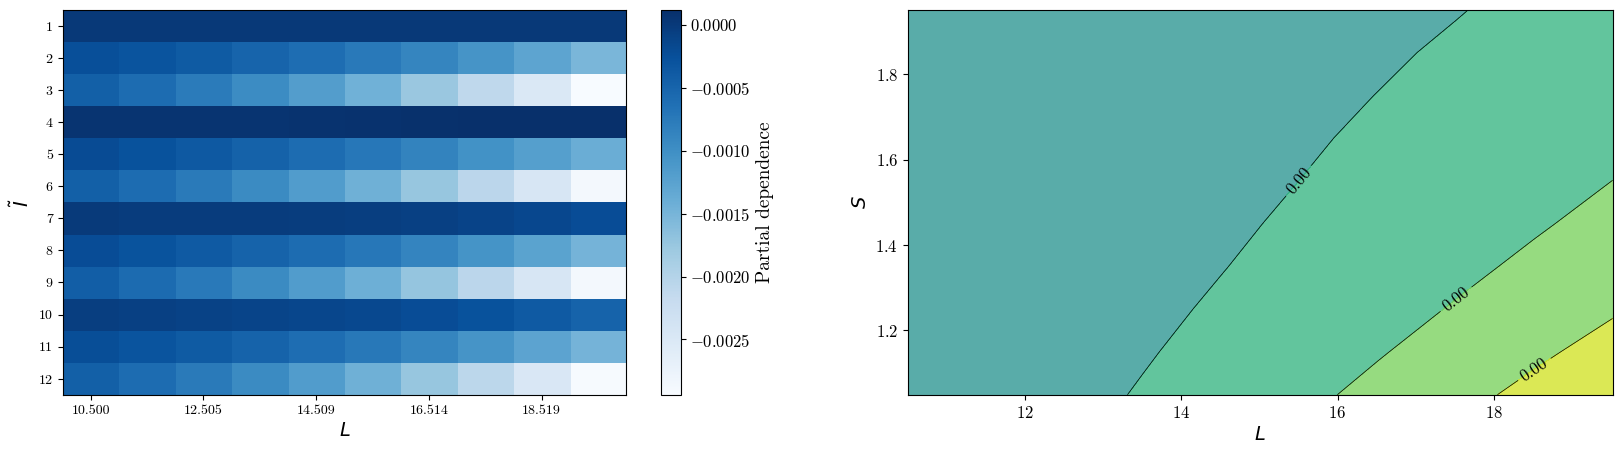

In [24]:
%%time
model = sm
features = [(0, 1), (1, 2)]

pdd_2d = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_feature_indices=categorical_feature_indices, 
    feature_names=feature_names,
    grid_resolution=10,
    kind='both',
    categories_map=categories_map,
    )

pdd_2d.plot(centered=True, figsize=[20, 5])